In [1]:

import yaml
import matplotlib.pyplot as plt
# from train_eval.trainer import Trainer
import torch
import torch.nn as nn
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"


In [69]:
unfold = nn.Unfold(kernel_size=(3, 3), dilation=1, padding=3//2, stride=(1, 1))
unfolded=unfold(test)
unfolded.shape

torch.Size([1, 27, 25])

In [77]:
unfolded.permute(0,2,1).view(1,5,5,-1,9).shape

torch.Size([1, 5, 5, 3, 9])

In [20]:
fold=nn.Fold(output_size=(5, 5), kernel_size=(3, 3), padding=3//2, dilation=1, stride=(1, 1))
fold(unfolded)/test

tensor([[[[4.0000, 6.0000, 6.0000, 6.0000, 4.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [4.0000, 6.0000, 6.0000, 6.0000, 4.0000]],

         [[4.0000, 6.0000, 6.0000, 6.0000, 4.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [6.0000, 9.0000, 9.0000, 9.0000, 6.0000],
          [4.0000, 6.0000, 6.0000, 6.0000, 4.0000]]]])

In [ ]:
def get_unfolded_feature(feature,kernel,mask):
    ## Input shape B,C,H,W
    channel=feature.shape[1]
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded_feature=unfold(feature).permute(0,2,1) ## B,Number of slided window, channel*Number of elements in every window
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    current_node_feat=feature.view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    target_feat=[]
    source_feat=[]
    for idx,batch in enumerate(current_node_feat):
        source_feat.append(batch[mask[idx]])
        target_feat.append(unfolded_feature[idx][mask[idx]])
    return source_feat,target_feat
source_feat,target_feat=get_unfolded_feature(op,15,mask_map)

In [2]:
with open("/home/stanliu/code/pgp/PGP/configs/raster_home_debug.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [3]:
from train_eval.trainer import Trainer
# from torch.utils.tensorboard import SummaryWriter
# import os
# writer = SummaryWriter(log_dir=os.path.join('/home/stanliu/code/pgp/PGP/output/test_ram', 'tensorboard_logs'))
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_home_mini","output/test_home_original/checkpoints/8.tar")
# trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_home")

# trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess")

2023-03-12 18:56:15,288	INFO worker.py:1518 -- Started a local Ray instance.


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 1.505 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.

Loading checkpoint from output/test_home_original/checkpoints/8.tar ... Done


In [ ]:
# self = trainer
# self.add_img=False
# with torch.no_grad():
#     val_epoch_metrics = self.run_epoch('val', self.val_dl)
# self.print_metrics(val_epoch_metrics, self.val_dl, mode='val')

In [4]:
import train_eval.utils as u
for i,data in enumerate(trainer.tr_dl):
    torch.cuda.empty_cache()
    # Load data
    data = u.send_to_device(u.convert_double_to_float(data))
    data_test=data['inputs']
    gt_test=data['ground_truth']

    break


In [9]:
focal=trainer.losses[0]
ade=trainer.losses[1]
# dri_loss=trainer.losses[1]


In [13]:
true_heatmap,gs_map = focal.generate_gtmap(data['ground_truth']['traj'],data_test['map_representation']['mask'].type(torch.bool))
data['ground_truth']['traj'][:,-1]

tensor([[ 4.0441e+00,  4.0862e+01],
        [-2.0498e-01,  1.2323e+01],
        [ 7.0848e-02,  6.7700e+01],
        [-2.1017e+01,  1.4381e+01],
        [ 7.9941e-02,  1.6247e+01],
        [-1.5324e-01, -4.6756e+00],
        [ 3.2780e-01,  6.8215e+00],
        [-1.4441e+00,  5.4008e+01],
        [-3.5566e+00,  2.8642e+01],
        [-8.6574e-01,  2.2486e+01],
        [-5.6784e-01,  7.1970e+01],
        [-1.6082e+00,  1.2710e+01],
        [ 2.8555e+01,  1.9940e+01],
        [ 3.7682e+00,  4.2764e+01],
        [ 3.3983e-01,  5.3592e+01],
        [ 2.0772e-02,  2.4337e+01]], device='cuda:0')

In [5]:
trainer.model.aggregator.teacher_force=True
trainer.model.decoder.teacher_force=True
data_test['gt_traj']=data['ground_truth']['traj']

In [14]:
if trainer.pretrain_mlp:
    data_test['gt_traj']=data['ground_truth']['traj']
else:
    data_test['gt_traj']=None   

In [11]:
# data['ground_truth']['traj']
map_representation = data_test['map_representation']['image']
mask=data_test['map_representation']['mask']


mask.shape

torch.Size([16, 488, 488])

In [10]:
data_test['surrounding_agent_representation'].keys()

dict_keys(['vehicles', 'pedestrians', 'image'])

In [12]:
traj_hist=data_test['target_agent_representation']

In [10]:
from models.library.blocks import *
class Home_MLP_deocder(nn.Module):
    def __init__(self, in_features,trajectory_hist_length,emb_size=32,horizon=12):
        super(Home_MLP_deocder, self).__init__()
        self.traj_encoder=nn.Sequential(
            nn.Flatten(1),
            leaky_MLP(in_features*trajectory_hist_length, emb_size)
        )
        self.traj_decoder=nn.Sequential(
            leaky_MLP(emb_size+2,64),
            nn.Linear(64,horizon*2)
        )

    def forward(self,traj_hist,diff):
        traj_emb=self.traj_encoder(traj_hist)
        x=torch.cat((traj_emb,diff),-1)
        trajs=self.traj_decoder(x)
        return trajs
test_decoder=Home_MLP_deocder(7,5)

In [13]:
self=trainer.model.decoder
gt_traj=data['ground_truth']['traj']
final_points=gt_traj[:,-1]

test_decoder(traj_hist,final_points).shape

torch.Size([1, 24])

In [ ]:
from models.library.RasterSampler import *
sampler = Sampler(cfg['aggregator_args'],resolution=1.0,apply_mask=True)
nodes_2D=sampler.sample_goals(mask)
mask_under=sampler.sample_mask(mask)

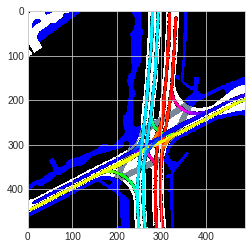

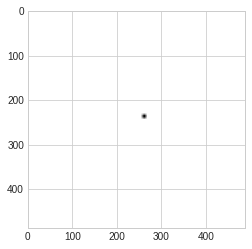

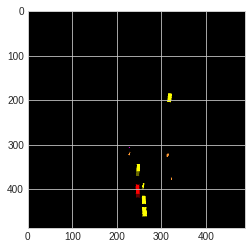

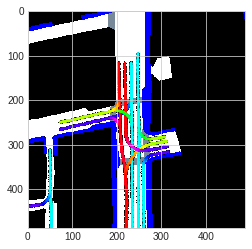

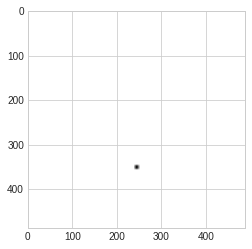

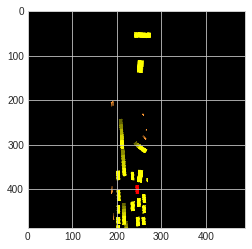

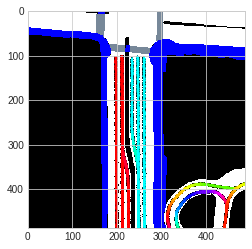

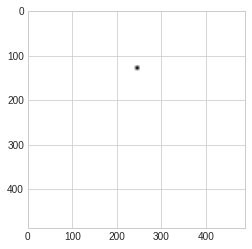

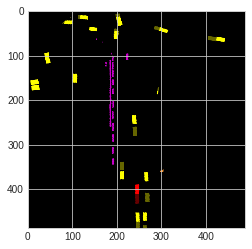

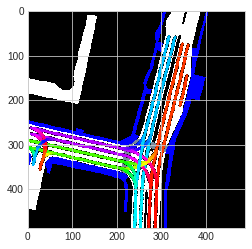

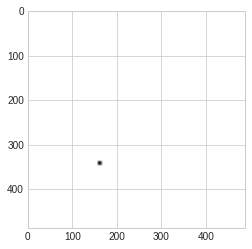

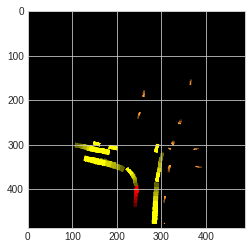

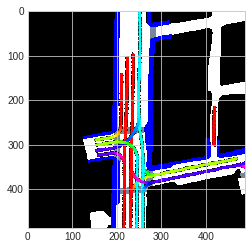

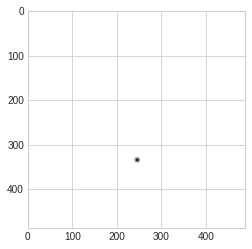

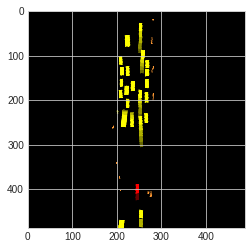

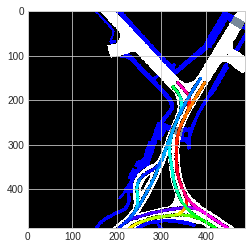

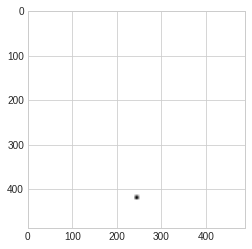

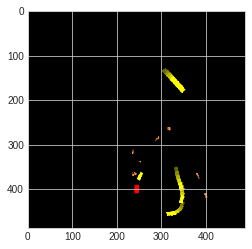

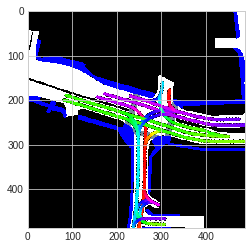

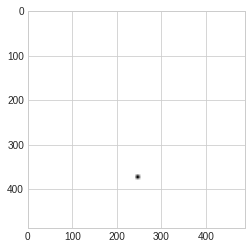

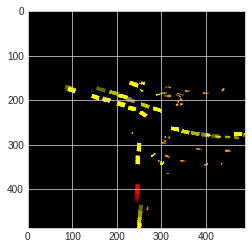

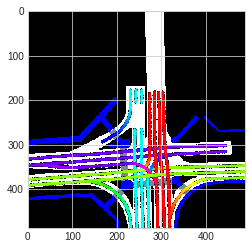

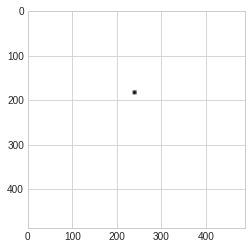

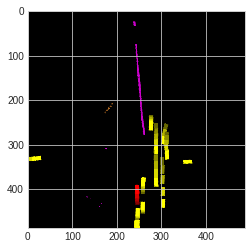

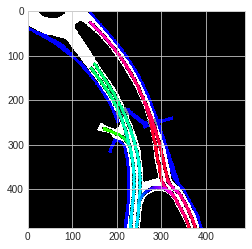

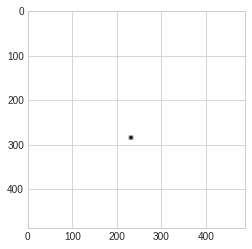

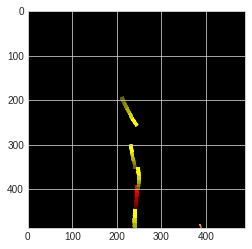

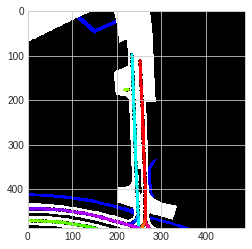

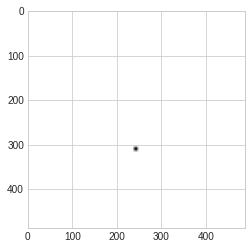

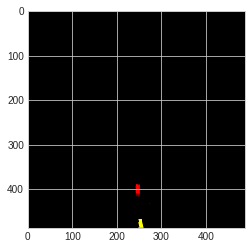

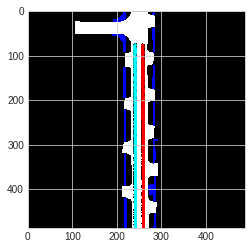

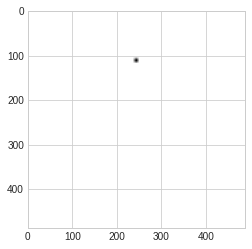

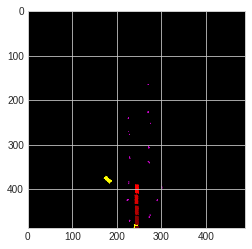

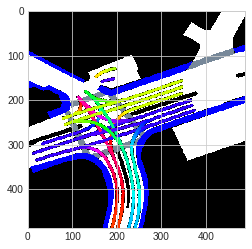

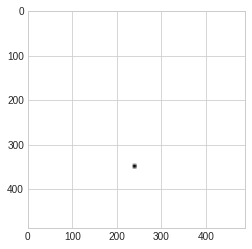

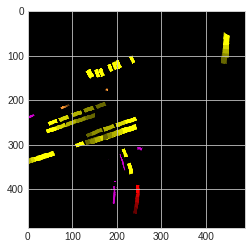

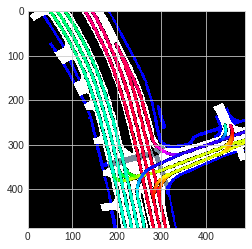

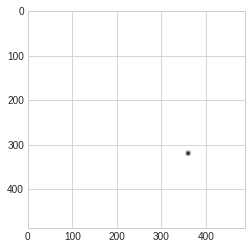

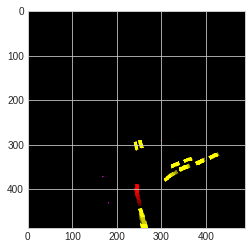

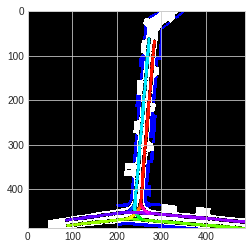

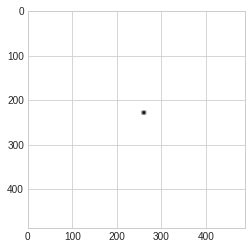

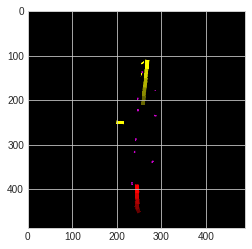

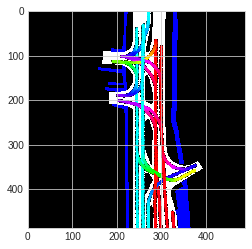

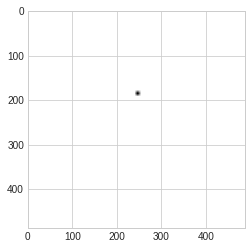

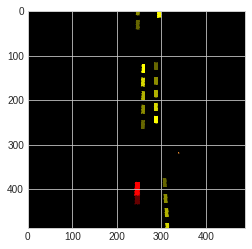

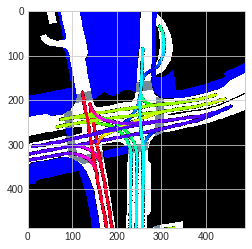

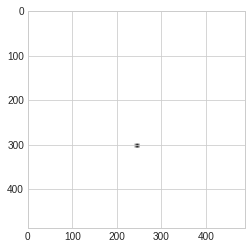

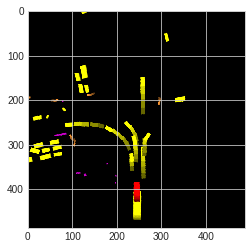

In [12]:
import matplotlib.pyplot as plt
for idx in range(16):
    surrounding_agents=data_test['surrounding_agent_representation']['image'][idx]
    plt.imshow(map_representation[idx].permute(1,2,0).cpu())
    plt.show()
    plt.imshow(gs_map[idx,0].cpu())
    plt.show()
    plt.imshow(surrounding_agents.permute(1,2,0).cpu())
    plt.show()
    # plt.imshow(mask[idx].cpu())
    # plt.show()

In [3]:
import torch
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss#/gauss.sum()
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 0.8).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
window=create_window(5, 1)
window


tensor([[[[0.0019, 0.0201, 0.0439, 0.0201, 0.0019],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0439, 0.4578, 1.0000, 0.4578, 0.0439],
          [0.0201, 0.2096, 0.4578, 0.2096, 0.0201],
          [0.0019, 0.0201, 0.0439, 0.0201, 0.0019]]]])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test['surrounding_agent_representation'][4,:3].permute(1,2,0))
plt.show()
# plt.imshow(test_heatmap[0,0])
# plt.show()
# data['ground_truth']['traj']

In [ ]:
data_test['map_representation'].keys()

In [ ]:
print('lane_node_feats has shape of ',data_test['map_representation']['lane_node_feats'].shape)
print('lane_node_masks has shape of ',data_test['map_representation']['lane_node_masks'].shape)
print('s_next has shape of ',data_test['map_representation']['s_next'].shape)
print('edge_type has shape of ',data_test['map_representation']['edge_type'].shape)

In [8]:
inputs=data_test
data_test.keys()

dict_keys(['instance_token', 'sample_token', 'map_representation', 'surrounding_agent_representation', 'target_agent_representation'])

In [20]:
torch.norm(trainer.model.encoder.target_agent_encoder.conv1d.conv1.weight)

tensor(4.5392, device='cuda:0', grad_fn=<CopyBackwards>)

In [25]:
total_norm=0
for p in trainer.model.parameters():
    
    param_norm = p.grad.data.norm(2)
    if torch.isnan(param_norm):
        print(type(p),p.size())
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)

<class 'torch.nn.parameter.Parameter'> torch.Size([384, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 128])


In [6]:
from torch.autograd.profiler import profile
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    encodings=trainer.model.encoder(data_test)
print(prof.key_averages().table(sort_by='cuda_time', row_limit=10))

In [33]:
encodings.keys()

dict_keys(['target_agent_encoding', 'context_encoding', 'gt_traj'])

In [7]:
encodings['target_agent_encoding'].sum(-1)

tensor([ 0.0000e+00,  2.3842e-07,  2.3842e-06, -2.3842e-06,  0.0000e+00,
         3.8147e-06,  9.5367e-07, -2.3842e-06,  1.4305e-06, -2.8610e-06,
        -2.3842e-06,  5.4836e-06, -2.3842e-07,  2.6226e-06,  2.3246e-06,
        -1.9073e-06], device='cuda:0', grad_fn=<SumBackward1>)

In [13]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    agg_feat=trainer.model.aggregator(encodings)
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))
torch.cuda.empty_cache()
# connectivities=agg_feat['node_connectivity']
# mask_map=agg_feat['under_sampled_mask']
# init=agg_feat['initial_states']
# print(connectivities.requires_grad)
# print(mask_map.requires_grad)

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    aten::conv2d         0.91%      78.618us        56.73%       4.906ms       2.453ms      34.815us         0.31%       7.732ms       3.866ms           0 b           0 b      64.03 Mb           0 b             2  
               aten::convolution         0.83%      71.704us        55.82%

In [9]:
print(agg_feat.keys())
# print(agg_feat['node_connectivity'].shape)
# inputs=agg_feat
# attn_output_weights = inputs['node_connectivity']
# print(attn_output_weights[0].shape)
# init_states=inputs['initial_states']
# target_encodings = inputs['target_encodings']
# map_feature=inputs['feature'].permute(0,2,3,1) 
# mask=inputs['under_sampled_mask']  
      
# print(agg_feat['node_connectivity'].shape)
# print((agg_feat['initial_states'].indices().nelement() * agg_feat['initial_states'].indices().element_size() + agg_feat['initial_states'].values().nelement() *agg_feat['initial_states'].values().element_size()) / 1024**2)

dict_keys(['agg_encoding', 'under_sampled_mask', 'target_encodings', 'traj_feature', 'gt_traj'])


In [8]:
self=trainer.model.decoder
inputs=agg_feat
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask']
    else:
        mask=None
    
if self.output_traj:
    target_encodings = inputs['target_encodings']
if 'traj_feature' in inputs:
    target_encodings = inputs['traj_feature']
predictions=self.decoding_net(agg_encoding)

In [9]:
map_feature=agg_encoding.flatten(2).permute(2,0,1)
# nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask,self.H,self.W)
dense_pred=predictions[:,-1].unsqueeze(1)
endpoints,confidences = self.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,self.num_target,self.feature_dim],device=predictions.device)
x_coord,y_coord=torch.meshgrid(torch.arange(self.map_extent[-1],self.map_extent[-2],-self.resolution)-self.resolution/2, ##### SHould be changed when image size changes
                                torch.arange(self.map_extent[0],self.map_extent[1],self.resolution)+self.resolution/2)
indices=torch.cat([y_coord.unsqueeze(-1),x_coord.unsqueeze(-1)],dim=-1).to(predictions.device)

In [12]:
for batch_idx in range(len(dense_pred)):
    diff = (indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]).float()
    feature=torch.cat([self.diff_encoder(diff),target_encodings[batch_idx].repeat(self.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [12]:
print(len(agg_feat['node_connectivity']))
print(agg_feat['under_sampled_mask'].shape)

torch.Size([16, 59536])


In [8]:
agg_encoding = agg_feat['agg_encoding']
mask=agg_feat['under_sampled_mask']

In [10]:
agg_feat.keys()

dict_keys(['agg_encoding', 'under_sampled_mask', 'target_encodings', 'traj_feature', 'gt_traj'])

In [13]:
agg_feat['target_encodings'].sum(-1)


tensor([ 4.1723e-06,  2.8610e-06, -1.9073e-06, -3.3379e-06,  3.3379e-06,
         0.0000e+00, -2.1458e-06,  5.2452e-06, -2.8610e-06,  1.4305e-06,
         9.5367e-07,  2.3842e-06,  2.8610e-06, -9.5367e-07, -3.4571e-06,
         1.6689e-06], device='cuda:0', grad_fn=<SumBackward1>)

In [11]:
self=trainer.model.decoder
print(self.decoding_net)
x=agg_encoding
for i,layer in enumerate(self.decoding_net):
    x=layer(x)
predictions=self.sigmoid(x)


ModuleList(
  (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(16, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
)


In [12]:
focal=trainer.losses[0]
traj_gt = gt_test['traj']
mask_da=mask
_,gs_map=focal.generate_gtmap(traj_gt,mask_da)

In [ ]:
import matplotlib.pyplot as plt
query_images=predictions[:,-1].detach().cpu()
gt_image=torch.clamp(gs_map.sum(dim=1),max=1.0).detach().cpu()
query_num=cfg['batch_size']
fig, ax = plt.subplots(query_num, 2, figsize=(10, 40))
fig.tight_layout()
for i in range(query_num):
    ax[i, 0].imshow(query_images[i])
    ax[i, 0].set_title(i)
    ax[i, 1].imshow(gt_image[i])

In [22]:
focal.compute({'pred': predictions,'mask': mask},gt_test)

tensor(20327.2539, device='cuda:0', grad_fn=<DivBackward0>)

In [10]:
self = trainer.model.aggregator
# mask=agg_feat['under_sampled_mask']
# feature=agg_feat['node_connectivity']
# init_pos=torch.zeros([self.H,self.W],device=feature[0].device)
# init_pos[self.compensation[0],self.compensation[1]]=1
### Goes to aggregator

In [10]:
target_agent_enc = encodings['target_agent_encoding']
context_enc = encodings['context_encoding']
if context_enc['combined'] is not None:
    combined_enc, map_mask = context_enc['combined'], context_enc['map_masks'].bool()
else:
    combined_enc, _ = self.get_combined_encodings(context_enc)

augmented_target_agent_enc = target_agent_enc.unsqueeze(2).unsqueeze(3).repeat(1,1,combined_enc.shape[-2],combined_enc.shape[-1])
concatenated_encodings=torch.cat([combined_enc,augmented_target_agent_enc],dim=1)
context_encoding = self.dim_reduction_block(concatenated_encodings)##Fuse agent feat with map feat by compressing the dimension (actually is linear layer)
augmented_encoding = self.transpose_conv(context_encoding)
augmented_encoding = augmented_encoding + self.pos_enc(augmented_encoding)
context_encoding = context_encoding.view(context_encoding.shape[0], context_encoding.shape[1], -1)## [Batch number, channel, H*W]
context_encoding = context_encoding.permute(0, 2, 1)## [Batch number, H*W, channel]

nodes_2D=self.sampler.sample_goals().repeat(context_encoding.shape[0],1,1).type(torch.float32)
torch.cuda.empty_cache()
query = self.query_emb(nodes_2D).permute(1,0,2)
keys = self.key_emb(context_encoding).permute(1, 0, 2)
vals = self.val_emb(context_encoding).permute(1, 0, 2)
mask_map=(self.sampler.sample_mask(map_mask))
if self.apply_mask:
    
    attn_mask=~mask_map.unsqueeze(-1).repeat(self.num_heads,1,context_encoding.shape[1])
    attn_output, _ = self.mha(query, keys, vals, attn_mask=attn_mask)
    attn_output[torch.isnan(attn_output)]=0
else:
    attn_output, _ = self.mha(query, keys, vals)
torch.cuda.empty_cache()
op = attn_output.permute(1,0,2)
op = op.view(op.shape[0],self.sampler.H,self.sampler.W,-1)
# op = torch.cat((target_agent_enc, op), dim=-1)
if self.conv:
    op=self.final_convs(op.permute(0,3,1,2))
    op=op+self.pos_enc(op)
torch.cuda.empty_cache()

### Desired shape for fold function
$$[B,H*W,conv\_kernel^2]$$

### TODO
1. Get reduced feature with shape $[B,num\_valid\_nodes,conv\_kernel^2,channel]$
2. Applied MLP on reduced feature and get `connectivity` with shape $[B,num\_valid\_nodes,conv\_kernel^2,1]$
3. Recover the reduced `connectivity` to full connectivity with shape $[B,H*W,conv\_kernel^2]$


In [11]:
def get_unfolded_feature(feature,mask,augmented_encoding):
        ## Input shape B,C,H,W
    kernel=self.conv_kernel
    # diff=self.get_diff().to(feature.device)
    # diff_encoding=self.diff_encoder(diff.view(2,-1).permute(1,0))
    torch.cuda.empty_cache()
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded=unfold(feature).permute(0,2,1)
    unfolded=(unfolded.view(feature.shape[0],self.H,self.W,-1,self.conv_kernel**2)[:,:-(self.source_row-self.center_row)]).transpose(-1,-2)
    # unfolded=torch.cat((unfolded,diff_encoding.repeat(unfolded.shape[0],unfolded.shape[1],unfolded.shape[2],1,1)),dim=-1)#.view(unfolded_feature.shape[0],unfolded_feature.shape[1],unfolded_feature.shape[2],-1)
    unfolded=unfolded.view(unfolded.shape[0],unfolded.shape[1]*unfolded.shape[2],self.conv_kernel**2,unfolded.shape[-1])## B*Number of slided window,kernel_size**2, channel
    # target_mask=mask.view(mask.shape[0],self.H,self.W)[:,:-(self.source_row-self.center_row)].view(mask.shape[0],-1)
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    # current_node_feat=feature[:,:,(self.source_row-self.center_row):].view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    source_mask=mask.view(mask.shape[0],self.H,self.W)[:,(self.source_row-self.center_row):].view(mask.shape[0],-1)
    augmented_encoding=augmented_encoding.permute(0,2,3,1)[:,(self.source_row-self.center_row):]
    augmented_encoding=augmented_encoding.view(augmented_encoding.shape[0],-1,augmented_encoding.shape[-1]).unsqueeze(-2)
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    summed_feat=torch.zeros([0,self.conv_kernel**2,augmented_encoding.shape[-1]],device=feature.device)
    for idx,batch in enumerate(unfolded):
        summed_feat=torch.cat((summed_feat,(batch+augmented_encoding[idx])[source_mask[idx]]),dim=0)
    # source_mask=torch.cat((source_mask,torch.zeros([mask.shape[0],mask.shape[-1]-source_mask.shape[-1]],device=mask.device)),dim=-1)
    # source_feat=(current_node_feat.unsqueeze(-2).repeat(1,1,self.conv_kernel**2,1)*source_mask).view(-1,channel).to_sparse()
    # target_feat=(unfolded*source_mask).view(-1,unfolded.shape[-1]).to_sparse()
    # torch.cuda.empty_cache()
    # concat_feature=torch.cat((target_feat,source_feat),dim=-1)

    return summed_feat,source_mask

In [65]:
def fake_unfold(feature,mask,augmented_encoding):
    points=torch.cat((self.compensation.unsqueeze(0),torch.Tensor([[186,113],[203,129]]).cuda()),dim=0).long()
    ind0=points[:,0]-(self.source_row-self.center_row)
    ind1=points[:,1]
    channel=augmented_encoding.shape[1]
    B=feature.shape[0]
    torch.cuda.empty_cache()
    unfolded=torch.zeros([B,self.H,self.W,self.conv_kernel**2,channel],device=feature.device)
    unfolded[:,ind0,ind1]=1
    unfolded=unfolded[:,:-(self.source_row-self.center_row)]
    torch.cuda.empty_cache()
    
    unfolded=unfolded.view(unfolded.shape[0],unfolded.shape[1]*unfolded.shape[2],self.conv_kernel**2,unfolded.shape[-1])
    source_mask=mask.view(mask.shape[0],self.H,self.W)[:,(self.source_row-self.center_row):].view(mask.shape[0],-1)
    summed_feat=torch.zeros([0,self.conv_kernel**2,channel],device=feature.device)
    for idx,batch in enumerate(unfolded):
        summed_feat=torch.cat((summed_feat,batch[source_mask[idx]]),dim=0)
    return summed_feat,source_mask

In [15]:
torch.cuda.empty_cache()

In [13]:
mask=mask_map.view(mask_map.shape[0],self.H,self.W).clone()
mask[:,:(self.source_row-self.center_row)]=False
mask=mask.view(mask_map.shape[0],-1)

In [14]:
summed_feat,source_mask=get_unfolded_feature(op,mask,augmented_encoding)
# summed_feat,source_mask=fake_unfold(op,mask,augmented_encoding)
# connectivities=self.concat_feat(source_feat,target_feat,diff)
torch.cuda.empty_cache()

In [15]:
print(summed_feat.shape)
self.deocde_block

torch.Size([50009, 361, 36])


Sequential(
  (0): Linear(in_features=36, out_features=18, bias=True)
  (1): LayerNorm()
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=18, out_features=9, bias=True)
  (4): LayerNorm()
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=9, out_features=1, bias=True)
)

In [16]:
connectivity=self.softmax(self.deocde_block(summed_feat).squeeze(-1))
# connectivity=summed_feat[:,:,0].squeeze(-1)
unfolded_base=torch.zeros(mask.shape[0],self.H*self.W,self.conv_kernel**2,device=op.device)
indices=torch.nonzero(mask)
ind0=indices[:,0]
ind1=indices[:,1]
unfolded_base[ind0,ind1]=connectivity
torch.cuda.empty_cache()


In [17]:
self=trainer.model.aggregator
init_pos=torch.zeros([self.H,self.W],device=connectivity.device)
init_pos[self.compensation[0],self.compensation[1]]=1
init_states=init_pos.repeat(mask.shape[0],1,1).view(mask.shape[0],-1).unsqueeze(-1)
prev_states=init_states.clone()
fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))

In [18]:
self=trainer.model.decoder
predictions=torch.empty([init_states.shape[0],0,self.H,self.W],device=unfolded_base.device)
for step in range(self.horizon):
    unfolded_map=(prev_states*unfolded_base).transpose(-1,-2)
    prob_map=torch.cat((fold(unfolded_map)[:,:,5:],torch.zeros([mask.shape[0],1,5,self.W],device=mask.device)),dim=2)
    predictions=torch.cat((predictions,prob_map),dim=1)
    # prev_map=torch.cat((prob_map[:,:,5:],torch.zeros([prob_map.shape[0],1,5,self.W],device=prob_map.device)),dim=2)
    prev_states=prob_map.view(init_states.shape[0],self.H*self.W,1)

In [29]:

pad_mask=((agg_feat['under_sampled_mask'].clone().view(mask.shape[0],self.H,self.W))[:,(self.source_row-self.center_row):]).view(mask.shape[0],-1)
unfold_base=torch.zeros([1,self.conv_kernel**2,(self.source_row-self.center_row)*self.W],device=feature[0].device)
unfold_feature=torch.zeros([0,self.conv_kernel**2,self.H*self.W],device=feature[0].device)
for batch_id,batch in enumerate(pad_mask):
    unfold_batch=unfold_base.clone()
    valid_count=0
    for node_id,node_validity in enumerate(batch):
        if node_validity:
            unfold_batch=torch.cat((unfold_batch,feature[batch_id][valid_count].view(1,-1,1)),dim=-1)
            valid_count+=1
        else:
            unfold_batch=torch.cat((unfold_batch,torch.zeros([1,self.conv_kernel**2,1],device=feature[0].device)),dim=-1)
    unfold_feature=torch.cat((unfold_feature,unfold_batch),dim=0)
    

In [10]:
def get_next(prev_states,feature,mask,indices):
    # unfold_base=torch.zeros([1,self.conv_kernel**2,(self.source_row-self.center_row)*self.W],device=feature[0].device)
    # unfold_feature=torch.zeros([0,self.conv_kernel**2,self.H*self.W],device=feature[0].device)
    unfold_base=torch.zeros([len(feature),self.conv_kernel**2,self.H*self.W],device=feature[0].device)
    for node_idx in indices:
        ## Get valid count
        if mask[node_idx[0],node_idx[1]]==True:
            valid_count=mask[node_idx[0],:node_idx[1]+1].sum().long()
            unfold_base[node_idx[0],:,node_idx[1]-self.W*(self.source_row-self.center_row)]=unfold_base[node_idx[0],:,node_idx[1]-self.W*(self.source_row-self.center_row)]+feature[node_idx[0]][valid_count-1]*prev_states[node_idx[0],node_idx[1]]
    fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))
    return fold(unfold_base)

In [11]:
### Goes to decoder
self.horizon=12
predictions=torch.empty([len(feature),0,self.H,self.W],device=feature[0].device)
prev_states=init_pos.repeat([len(feature),1,1])
mask_filtered=mask.clone().view(mask.shape[0],self.H,self.W)
mask_filtered[:,:(self.source_row-self.center_row)]=False
for t in range(self.horizon):
    # prev_states[prev_states<1e-5]=0
    indices=torch.nonzero(prev_states.view(len(feature),-1))
    next_states=get_next(prev_states.view(len(feature),-1),feature,mask_filtered.view(mask.shape[0],-1),indices)
    # print(next_states.shape)
    predictions=torch.cat((predictions,next_states),dim=1)
    prev_states=next_states

In [12]:
predictions=self.softmax(predictions.view(predictions.shape[0],predictions.shape[1],-1)).view(predictions.shape[0],predictions.shape[1],self.H,self.W)

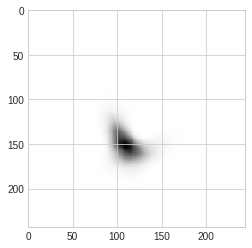

In [26]:
plt.imshow(predictions[1,-1].squeeze(0).detach().cpu())
plt.show()

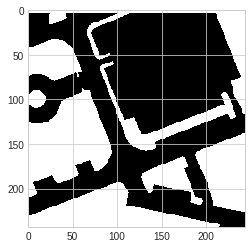

In [25]:
plt.imshow(mask[1].view(244,244).detach().cpu())
plt.show()

In [9]:

self=trainer.model.decoder


In [ ]:
# test_feat=op.view(op.shape[0],op.shape[1],-1).permute(0,2,1)
torch.cuda.empty_cache()
inputs=agg_feat


In [11]:
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask'].to(agg_encoding.device)
    else:
        mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
context_encoding = agg_encoding + self.pos_enc(agg_encoding)

In [12]:
torch.cuda.empty_cache()
context_encoding = context_encoding.view(context_encoding.shape[0], context_encoding.shape[1], -1)
feature = context_encoding.permute(0, 2, 1).unsqueeze(1).repeat(1,self.horizon,1,1)
x=self.decoding_net(feature).view(feature.shape[0],self.horizon,self.H,self.W)
torch.cuda.empty_cache()
predictions=self.sigmoid(x)

In [ ]:
inputs = agg_feat
if type(inputs) is torch.Tensor:
    agg_encoding = inputs
else:
    agg_encoding = inputs['agg_encoding']
    if 'under_sampled_mask' in inputs:
        mask=inputs['under_sampled_mask']
    else:
        mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
time_querys=torch.cat((self.querys_embedder(self.time_steps),self.time_steps),dim=-1).repeat(agg_encoding.shape[0],1,1).unsqueeze(2)

In [14]:

with profile( use_cuda=True,profile_memory=True, record_shapes=True) as prof:
    predictions=trainer.model.decoder(agg_feat)
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))
# print(predictions['pred'].element_size() * predictions['pred'].nelement()/ 1024**2)
# pred=predictions['pred'].to_sparse()
# print(pred.element_size() * pred.nelement()/ 1024**2)

# print((pred.indices().nelement() * pred.indices().element_size() + pred.values().nelement() * pred.values().element_size()) / 1024**2)

-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::_convolution_nogroup         0.05%      59.427us         5.08%       5.665ms       2.832ms      10.228us         0.01%      25.824ms      12.912ms           0 b           0 b     582.28 Mb           0 b             2  
          aten::slow_conv_transpose2d         0.96%   

In [9]:
predictions.keys()

dict_keys(['pred', 'mask', 'traj', 'probs', 'endpoints'])

In [11]:
sum=predictions['pred'].flatten(1).mean(dim=-1)
sum

torch.Size([16, 1, 968, 968])

In [10]:
predictions['pred'].shape

torch.Size([16, 1, 242, 242])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


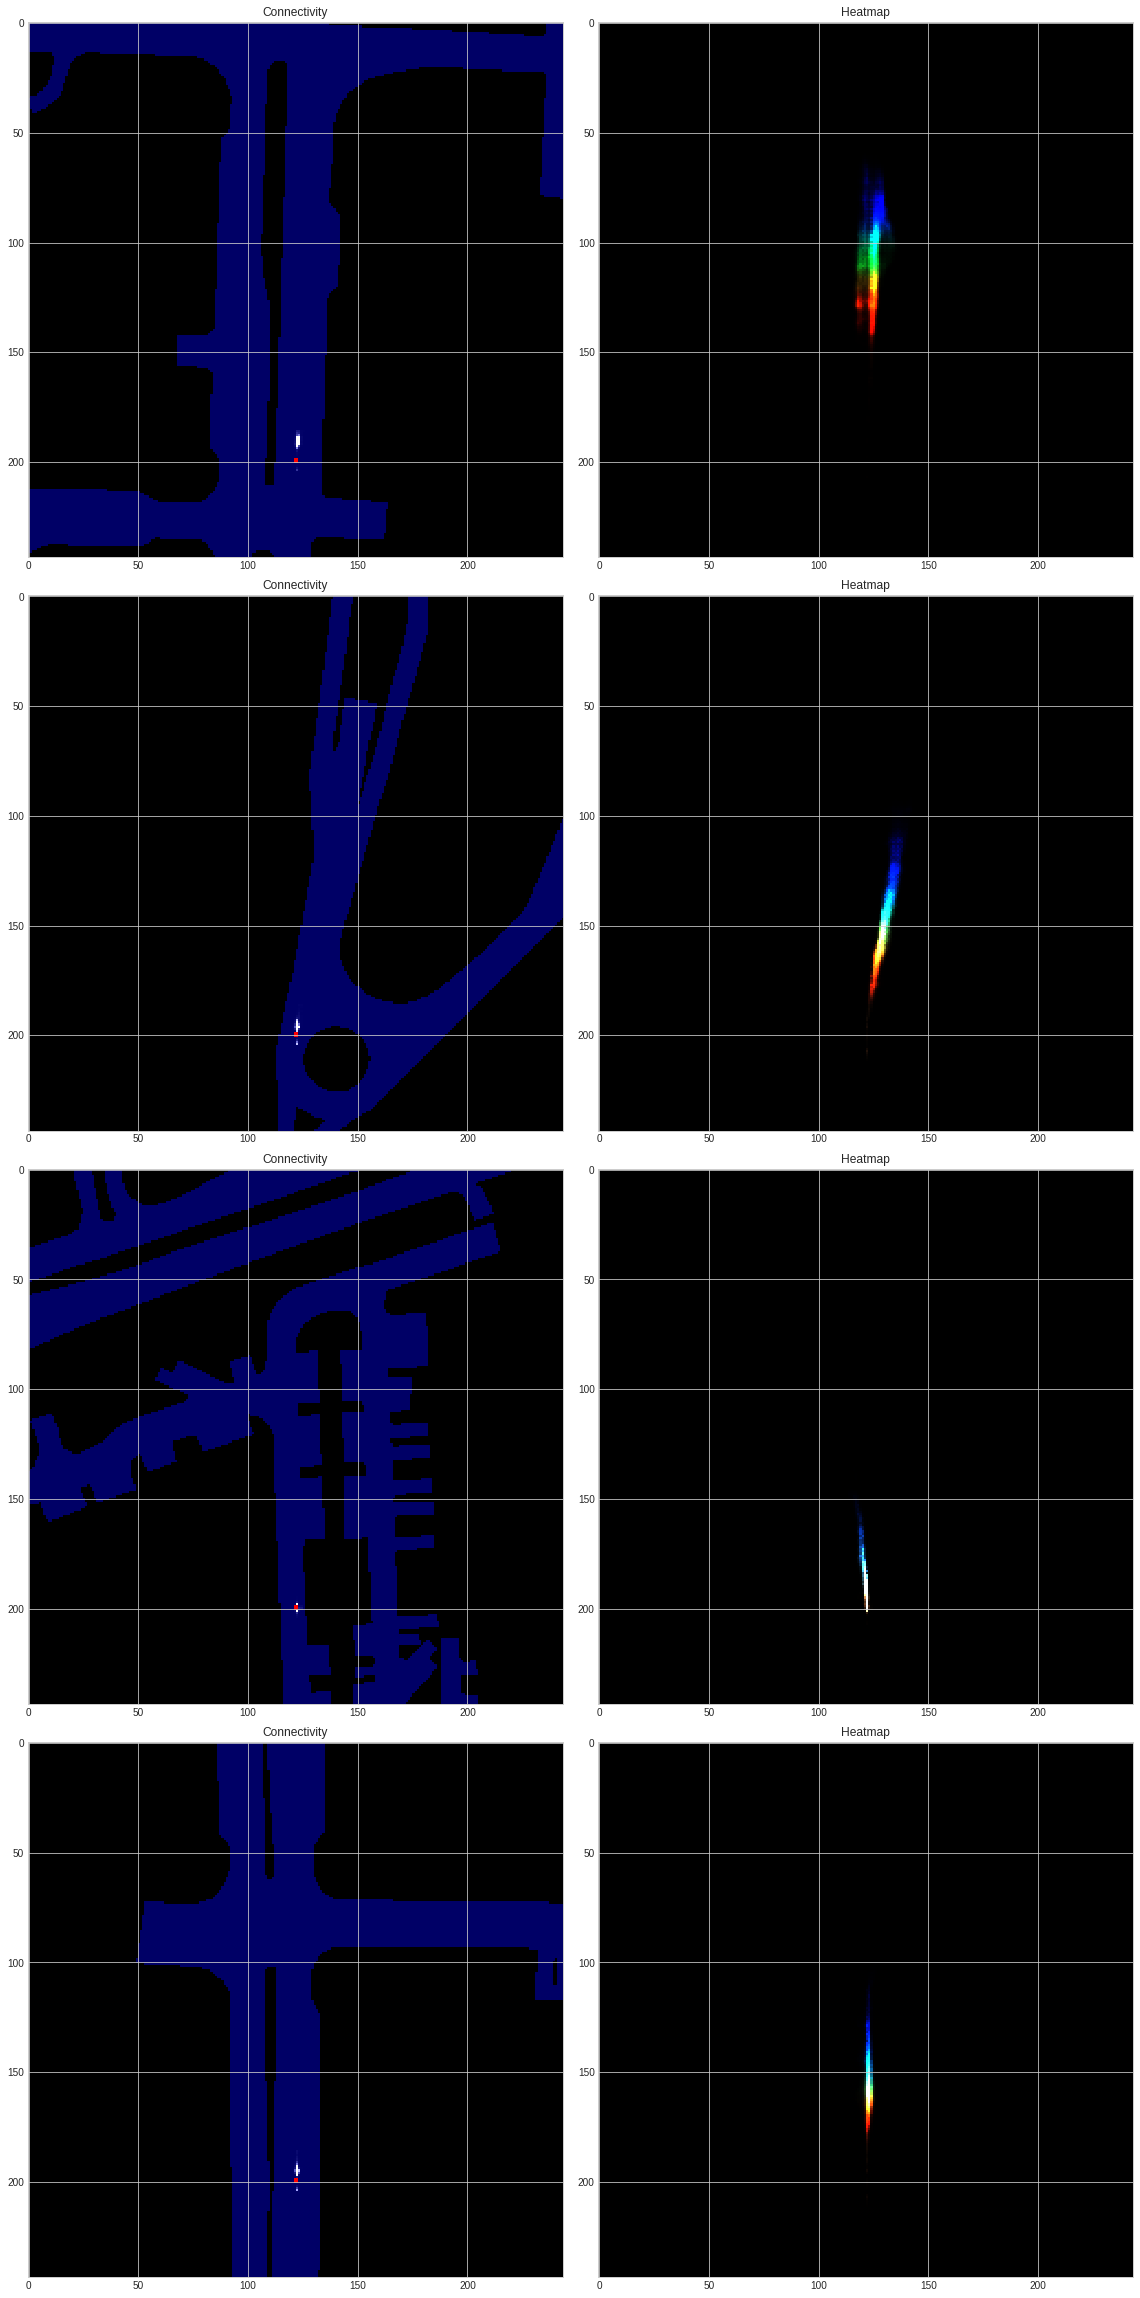

In [11]:
from models.decoders.ram_decoder import get_index,get_dense
self=trainer.model.aggregator
def get_heatmap(predictions,mask):
    if self.agg_type=='global':
        nodes_2D=get_index(predictions['pred'],mask)
        dense_pred=get_dense(predictions['pred'],nodes_2D,self.H,self.W).squeeze(1).clone().detach()
    else:
        dense_pred=predictions['pred'].clone().detach()
    heatmap=torch.cat((dense_pred[:,-5].unsqueeze(1),dense_pred[:,-3].unsqueeze(1),dense_pred[:,-1].unsqueeze(1)),dim=1)
    return heatmap.permute(0,2,3,1).cpu()
def visualize_connectivity(point,connectivity,mask,predictions):
    max_num=max(mask.sum(dim=1))
    init_pos=torch.zeros([self.H,self.W]).to(connectivity.device)
    init_pos[point[0],point[1]]=1
    state=init_pos.view(-1)
    fig, ax = plt.subplots(mask.shape[0], 2, figsize=(16, 8*mask.shape[0]))
    fig.tight_layout()
    if self.agg_type=='global':
        graphs=torch.empty([0,1,max_num]).to(connectivity.device)
        for i in range(mask.shape[0]):
            print(mask.view(mask.shape[0],self.H,self.W)[i,point[0],point[1]])
            reduced_state=((init_pos.view(-1))[mask[i]]).to_sparse()
            aug_state=torch.cat((reduced_state, torch.sparse_coo_tensor(torch.empty([1,0]), [], [max_num - reduced_state.size(0),]).to(connectivity.device)), 0).unsqueeze(0)
            reduced_graph=(aug_state.to_dense()@connectivity[i]).unsqueeze(1)
            graphs=torch.cat((graphs,reduced_graph),dim=0)
        nodes_2D=get_index(graphs,mask)
        dense_pred=get_dense(graphs,nodes_2D,self.H,self.W).squeeze(1).clone().detach().unsqueeze(1)
    else:
        init_states=init_pos.repeat(mask.shape[0],1,1).view(mask.shape[0],-1).unsqueeze(-1)
        fold=nn.Fold(output_size=(self.H, self.W), kernel_size=(self.conv_kernel, self.conv_kernel), padding=self.conv_kernel//2, dilation=1, stride=(1, 1))
        unfolded_map=(init_states*connectivity).transpose(-1,-2)
        dense_pred=torch.cat((fold(unfolded_map)[:,:,5:],torch.zeros([mask.shape[0],1,5,self.W],device=mask.device)),dim=2).clone().detach()
    # mask_map=dense_pred.clone()
    # mask_map[mask.view(dense_pred.shape)]=0.01
    # dense_pred+=mask_map
    # print(dense_pred.shape)
    dense_pred=dense_pred.repeat(1,3,1,1)
    dense_pred*=128
    dense_pred[:,2][mask.view(mask.shape[0],self.H,self.W)]+=0.4
    dense_pred[:,1:,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=0
    dense_pred[:,0,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=255
    
    dense_pred=dense_pred.permute(0,2,3,1)
    last_steps=get_heatmap(predictions,mask)*255
    # last_steps[:,1:,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=0
    # last_steps[:,0,point[0]-1:point[0]+1,point[1]-1:point[1]+1]=600
    # print(last_steps.shape)
    # print(dense_pred)
    for i in range(mask.shape[0]):
        # print(dense_pred[i].shape)

        ax[i, 0].imshow(dense_pred[i].cpu())
        ax[i, 0].set_title('Connectivity')
        ax[i, 1].imshow(last_steps[i])
        ax[i, 1].set_title('Heatmap')

    
visualize_connectivity(self.compensation,agg_feat['node_connectivity'],agg_feat['under_sampled_mask'],predictions)

In [10]:
inputs= agg_feat
self=trainer.model.decoder
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']

if 'under_sampled_mask' in inputs:
    mask=inputs['under_sampled_mask']
else:
    mask=None
if self.output_traj:
    target_encodings = inputs['target_encodings']
    map_feature=inputs['feature'].permute(0,2,3,1)

In [12]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()
for step in range(self.horizon):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

In [14]:
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask,self.H,self.W)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,self.H,self.W)

In [ ]:
traj_idx=0
idx=5
import matplotlib.pyplot as plt
gt_map=predictions['pred'][:,-1].detach()
mask_map=gt_map.clone()
mask_map[predictions['mask'].view(gt_map.shape)]=0.005
gt_map+=mask_map
plt.imshow(gt_map[idx].squeeze(0).cpu())
plt.show()


In [ ]:
# print(predictions['pred'].shape)
normalized_pred=predictions['pred']/(torch.max(predictions['pred'].detach(),dim=-1,keepdim=True)[0])
print(torch.max(predictions['pred'],dim=-1,keepdim=True)[0])
print(torch.max(normalized_pred,dim=-1,keepdim=True)[0])

In [60]:
focal=trainer.losses[0]
focal.horizon=12

In [ ]:
traj_idx=0
idx=0
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(predictions['traj'][:,traj_idx].view(predictions['traj'].shape[0],-1,predictions['traj'].shape[-1]).clone().detach(),predictions['mask'],visualize=True)
gt_map=torch.clamp(torch.sum(gt_map,dim=1,keepdim=True),0.0,1.0)
mask_map=gt_map.clone()
mask_map[predictions['mask'].view(gt_map.shape)]=0.005
gt_map+=mask_map
gt_map=gt_map.repeat(1,3,1,1)
gt_map*=127
endpoints=predictions['endpoints']
for batch in range(gt_map.shape[0]):
    for i,point in enumerate(endpoints[batch]):
        if i== traj_idx:
            x,y=point
            gt_map[batch,-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=255
            gt_map[batch,:-1,max(0,x-2):min(x+3,trainer.losses[0].H),max(0,y-2):min(trainer.losses[0].W,y+3)]=0
        else:
            x,y=point
            gt_map[batch,0,max(0,x-1):min(x+1,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=255
            gt_map[batch,1:,max(0,x-1):min(x+3,trainer.losses[0].H),max(0,y-1):min(trainer.losses[0].W,y+1)]=0

gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].cpu())
plt.show()
# plt.imshow(mask[idx])
# plt.show()
# gt_map.shape

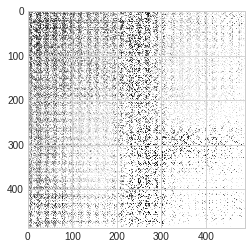

In [15]:
predictions['pred'].clone().detach()[1,-1].shape

plt.imshow(predictions['pred'].clone().detach()[0,-1].cpu())
plt.show()

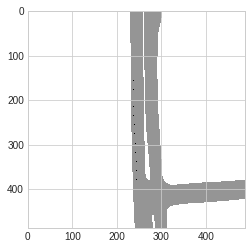

In [16]:
# idx=3
# traj_idx=0
import matplotlib.pyplot as plt
from models.decoders.ram_decoder import get_index,get_dense
gt_map=trainer.losses[0].generate_gtmap(data['ground_truth']['traj'],predictions['mask'],visualize=True)
gt_map=torch.sum(gt_map,dim=1,keepdim=True)
mask_map=torch.zeros_like(gt_map)
mask_map[predictions['mask'].view(gt_map.shape)]=1
gt_map+=mask_map
# gt_map=gt_map.permute(0,2,3,1)
# normalize_factor,_=torch.max(dense_pred.view(dense_pred.shape[0],-1),dim=-1)
plt.imshow(gt_map[idx].squeeze(0).cpu())
plt.show()

In [15]:
self=trainer.model.decoder
trajs=predictions['traj']
heatmaps=predictions['pred']
mask=agg_feat['under_sampled_mask']
shape=[mask.shape[0],self.horizon,self.H,self.W]
swapped=torch.zeros_like(trajs)
swapped[:,:,:,0],swapped[:,:,:,1]=-trajs[:,:,:,1],trajs[:,:,:,0]
coord=torch.round(swapped/self.resolution+self.compensation.to(swapped.device))
coord=torch.clamp(coord,0,shape[-1]).long()
coord.device


device(type='cuda', index=0)

In [16]:
horizon=coord.shape[-2]
B=coord.shape[0]
x_coord,y_coord=torch.meshgrid(torch.arange(B,device=coord.device), 
                            torch.arange(horizon,device=coord.device))
indices_front=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).long().unsqueeze(1).repeat(1,coord.shape[1],1,1)

# indices=torch.cat((indices_front,coord),dim=-1)
indices_front.device

device(type='cuda', index=0)

In [14]:
indices=torch.cat((indices_front,coord),dim=-1).long()
indices.device

device(type='cpu')

In [17]:
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(heatmaps,mask,self.H,self.W)
dense_pred=get_dense(heatmaps,nodes_2D,self.H,self.W)
# dense_pred.device
dense_pred.device

device(type='cuda', index=0)

In [ ]:
ind0=indices.view(-1,4)[:,0]
ind1=indices.view(-1,4)[:,1]
ind2=indices.view(-1,4)[:,2]
ind3=indices.view(-1,4)[:,3]
ind1


In [31]:
probs=dense_pred[ind0,ind1,ind2,ind3].view(B,coord.shape[1],horizon).sum(-1)

In [35]:
probs.sort(descending=True)

torch.return_types.sort(
values=tensor([[1.0372, 0.8492, 0.7616, 0.6335, 0.6223, 0.4670, 0.4462, 0.3702, 0.3455,
         0.3272, 0.3265, 0.3232, 0.2768, 0.2766, 0.2643, 0.2563, 0.2272, 0.2249,
         0.2210, 0.2205],
        [0.3282, 0.1116, 0.0635, 0.0494, 0.0465, 0.0298, 0.0283, 0.0281, 0.0262,
         0.0219, 0.0206, 0.0192, 0.0190, 0.0183, 0.0181, 0.0170, 0.0163, 0.0162,
         0.0159, 0.0148]], grad_fn=<SortBackward>),
indices=tensor([[ 5,  4,  6,  2,  0, 12,  1, 10,  9, 13,  3, 16, 11,  7, 17,  8, 18, 19,
         14, 15],
        [ 2,  0,  1,  4, 15, 13,  9,  6,  3, 17,  7, 19,  5,  8, 10, 11, 12, 14,
         18, 16]]))

In [ ]:
predictions['probs']

In [17]:

with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
   focal=trainer.losses[0]
   # loss=focal.compute({'pred':predictions,'mask':mask_map},gt_test)
   loss=focal.compute(predictions,gt_test)
   loss+=trainer.losses[1].compute(predictions,gt_test)
   loss+=trainer.losses[2].compute(predictions,gt_test)
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::conv2d         0.08%      23.967us         1.65%     464.907us     464.907us      21.502us         0.08%       8.510ms       8.510ms           0 b           0 b      14.54 Mb           0 b             1  
            aten::convolution         0.18%      49.466us         1.56%     440.940us 

In [14]:
ade=trainer.losses[1]
loss=ade.compute(predictions,gt_test)

In [20]:
from math import exp
window_size=9
gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*1.5**2)) for x in range(window_size)])
gauss

tensor([0.0286, 0.1353, 0.4111, 0.8007, 1.0000, 0.8007, 0.4111, 0.1353, 0.0286])

In [26]:
ade.compute(predictions,gt_test)

tensor(39.9779, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
torch.cuda.empty_cache()

In [18]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True, use_cuda=True) as prof:
   loss.backward()
print(prof.key_averages().table(sort_by="cuda_time", row_limit=10))

-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          SlowConvTranspose2DBackward         0.04%      89.080us         1.58%       3.315ms       1.657ms      30.742us         0.01%      30.234ms      15.117ms           0 b           0 b     290.28 Mb      -1.14 Gb       

In [33]:
predictions['mask'].sum(-1)


tensor([3181, 4249, 4796, 3145], device='cuda:0')

In [34]:
inputs = agg_feat
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']


mask=inputs['under_sampled_mask']
target_encodings = inputs['target_encodings']
map_feature=inputs['feature'].permute(0,2,3,1)

In [35]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()

for step in range(12):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

torch.cuda.empty_cache()

In [36]:
map_extent= [-61, 61, -22, 100]
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,122,122)
endpoints,confidences = trainer.model.decoder.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,12,90],device=attn_output_weights.device)
x_coord,y_coord=torch.meshgrid(torch.arange(map_extent[-1],map_extent[-2],-1), ##### SHould be changed when image size changes
                                torch.arange(map_extent[0],map_extent[1],1))
indices=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).to(attn_output_weights.device)
for batch_idx in range(len(dense_pred)):
    map_feat = (map_feature[batch_idx])[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]
    diff = indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]].float()

    feature=torch.cat([map_feat,trainer.model.decoder.diff_encoder(diff),target_encodings[batch_idx].repeat(trainer.model.decoder.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [ ]:
print(torch.cuda.memory_summary(0))

In [ ]:
pred=predictions['pred']
mask=predictions['mask']
traj_gt = gt_test['traj']

In [ ]:
import torch.nn.functional as F
with profile( profile_memory=True, record_shapes=True) as prof:
    swapped=torch.zeros_like(traj_gt).to(pred.device)
    swapped[:,:,0],swapped[:,:,1]=-traj_gt[:,:,1],traj_gt[:,:,0]
    coord=torch.round(swapped/trainer.losses[0].resolution+trainer.losses[0].compensation).int()
    coord=torch.clamp(coord,0,122)
    gt_map=torch.zeros([6,12,122,122],device=pred.device)
    for batch in range(6):
        for t in range(12):
            x,y=coord[batch,t]
            gt_map[batch,t,x,y]=1##Only one ground truth in each heatmap layer
    gs_map=F.conv2d(gt_map, trainer.losses[0].window, padding = trainer.losses[0].window_size//2, groups = trainer.losses[0].horizon)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss_mask = (reduced_gts == 1).float()
    pred_heatmap = torch.clamp(pred, min=1e-4)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss=-torch.sum(
                    torch.pow(pred_heatmap - reduced_maps, 2) * (
                    loss_mask * torch.log(pred_heatmap)
                    +
                    (1-loss_mask) * (torch.pow(1 - reduced_maps, 4) * torch.log(1 - pred_heatmap))
                )
            )
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True) as prof:
    trainer.optimizer.step()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    gs_map=gs_map.view([6,12,-1])
    gt_map=gt_map.view([6,12,-1])
    max_num=max(mask.sum(dim=1))
    reduced_maps=[]
    reduced_gts=[]
    for i,batch in enumerate(gs_map):
        reduced_map=batch[mask[i].repeat(12,1)].view(12,-1)
        reduced_gt=gt_map[i][mask[i].repeat(12,1)].view(12,-1)
        aug_map=torch.cat((reduced_map, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        aug_gt=torch.cat((reduced_gt, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        reduced_maps.append(aug_map.unsqueeze(0))
        reduced_gts.append(aug_gt.unsqueeze(0))
    reduced_maps=torch.cat(reduced_maps,dim=0).to(pred.device)
    reduced_gts=torch.cat(reduced_gts,dim=0).to(pred.device)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
reduced_gts.sum()

In [ ]:
def get_index(pred,mask):
    x_coord,y_coord=torch.meshgrid(torch.arange(0,122,1),
                                torch.arange(0,122,1))
    nodes_candidates=torch.cat((x_coord.unsqueeze(0),y_coord.unsqueeze(0)),dim=0).view(2,-1).T
    nodes_2D=torch.zeros([mask.shape[0],pred.shape[-1],2])
    for i in range(mask.shape[0]):
        nodes_batch=nodes_candidates[mask[i]]
        nodes_2D[i,:nodes_batch.shape[0]]=nodes_batch
    return nodes_2D.int().permute(0,2,1).to(pred.device)
nodes_2D=get_index(pred,mask)
nodes_2D.shape

In [ ]:
def get_dense(pred,nodes_2D,H,W):
    dense_rep=torch.empty(0,pred.shape[1],H,W,device=pred.device)
    for batch in range(pred.shape[0]):
        batch_heatmap=torch.empty(0,H,W,device=pred.device)
        for step in range(pred.shape[1]):
            heatmap=torch.sparse_coo_tensor(nodes_2D[batch],pred[batch,step],(122,122))
            batch_heatmap=torch.cat((batch_heatmap,heatmap.to_dense().unsqueeze(0)),dim=0)
        dense_rep=torch.cat((dense_rep,batch_heatmap.unsqueeze(0)),dim=0)
    return dense_rep
dense_rep=get_dense(pred,nodes_2D,122,122)

In [ ]:
predictions['probs']=predictions['prob']

In [ ]:


with profile( profile_memory=True, record_shapes=True) as prof:

# loss=pred.sum()
    loss=focal.compute(predictions,gt_test)
    loss+=ade.compute(predictions,gt_test)
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
trainer.model.aggregator

In [ ]:
pred = predictions['pred']
mask_da = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
ground_truth = gt_test
traj_gt = ground_truth['traj'] if type(ground_truth) == dict else ground_truth
true_heatmap,gs_map = focal.generate_gtmap(traj_gt,pred.shape)
gs_map=gs_map*mask_da
mask = (true_heatmap == 1).float()
pred_heatmap = torch.clamp(pred, min=1e-4)

In [ ]:
loss= focal()

In [ ]:
loss.backward()

In [ ]:
pred = predictions['pred']
mask = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
non_drivable_area_mask=~mask

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(non_drivable_area_mask[0,0].cpu())
plt.show()
plt.imshow(torch.zeros_like(non_drivable_area_mask[0,0].cpu()))
plt.show()

In [ ]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

In [ ]:
import torch
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1].type(torch.bool)
mask.shape

In [ ]:
idx=10
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))

In [ ]:
from models.encoders.raster_encoder import *
encoder=RasterEncoder(cfg['encoder_args'])
# encodings=encoder.forward(data_test)

In [ ]:
encodings['context_encoding']["combined"].shape

In [ ]:
test_tensor=torch.randn([32,20,100,100])
test_walker=LocalWalk(radius=0.2)
test_walker.forward(test_tensor,test_tensor).shape

In [ ]:
from models.library.RasterSampler import *
sampler=Sampler(cfg['train_set_args'],1)

In [ ]:
fake_mask=torch.randn([32,488,488]).ge(0)
nodes_2D=sampler.sample_goals().repeat(32,1,1).type(torch.float32)
mask_under=(sampler.sample_mask(mask))
attn_mask=~mask_under.unsqueeze(-1).repeat(2,1,256)
print(attn_mask.shape)
print(mask.shape)
print(nodes_2D.shape)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(mask[0]))
plt.show()
plt.imshow(np.array(~mask_under[0].view(122,122)))
plt.show()

In [ ]:
with open("/home/stanliu/code/pgp/PGP/configs/preprocess_nuscenes.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [ ]:
from datasets.nuScenes.nuScenes_graphs import NuScenesGraphs
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)


In [ ]:
from nuscenes.prediction import PredictHelper
helper=PredictHelper(nusc)
graph_extractor=NuScenesGraphs('extract_data','/home/stanliu/code/pgp/PGP/preprocess',cfg['train_set_args'],helper)

In [ ]:
graph_extractor.max_nodes

In [ ]:
idx=0
i_t, s_t = graph_extractor.token_list[idx].split("_")
map_name = graph_extractor.helper.get_map_name_from_sample_token(s_t)
map_api = graph_extractor.maps[map_name]

# Get agent representation in global co-ordinates
global_pose = graph_extractor.get_target_agent_global_pose(idx)

# Get lanes around agent within map_extent
lanes = graph_extractor.get_lanes_around_agent(global_pose, map_api)

# Get relevant polygon layers from the map_api
polygons = graph_extractor.get_polygons_around_agent(global_pose, map_api)

# Get vectorized representation of lanes
lane_node_feats, lane_ids = graph_extractor.get_lane_node_feats(global_pose, lanes, polygons)


In [ ]:
polygons

In [ ]:
lane_node_feats, lane_ids = graph_extractor.discard_poses_outside_extent(lane_node_feats, lane_ids)

In [ ]:
e_succ = graph_extractor.get_successor_edges(lane_ids, map_api)
e_prox = graph_extractor.get_proximal_edges(lane_node_feats, e_succ)

In [ ]:

num_nbrs = [len(e_succ[i]) + len(e_prox[i]) for i in range(len(e_succ))]
max_nbrs = max(num_nbrs) if len(num_nbrs) > 0 else 0
num_nodes = len(lane_node_feats)


In [ ]:
print('num_nbrs',(num_nbrs))
print('max_nbrs',max_nbrs)
print('num_nodes',num_nodes)

In [ ]:
s_next, edge_type = graph_extractor.get_edge_lookup(e_succ, e_prox)

In [ ]:
from numpy import linalg as LA
lengths=[]
segment_lengths=[]
for idx in range(len(lane_node_feats)):
    lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1).sum())
    segment_lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1)[0])
print(lengths)
print(segment_lengths)

In [ ]:
import numpy as np
prev_feat=np.empty([0,5])
for feat in lane_node_feats[:2]:
    prev_feat=np.r_[prev_feat,feat]
idx=-10
import matplotlib.pyplot as plt
x=prev_feat[:,0]
y=prev_feat[:,1]
plt.scatter(x,y,s=2)